# Modelo de OneClassSVM entrenado con 4F de datos Astro, y predicción sobre datos Unid (no identificados)

**Proyecto**: Detección de posibles fuentes de materia oscura usando ML en datos Fermi-LAT  
**Autor**: Marta Canino Romero  
**Fecha**: febrero-mayo 20225

---

## Descripción:

Este notebook aplica un modelo **One-Class SVM** entrenado con datos de fuentes astrofísicas conocidas (ASTRO) usando las siguientes características:

- E_peak
- beta
- sigma
- betaRel

Este modelo se entrena para identificar anomalías que puedan corresponder a posibles fuentes de materia oscura (UNIDs) en los datos no identificados del catálogo 4FGL.

---

## Objetivos específicos:

- Entrenar modelo OCSVM con [número de features] 
- Optimizar hiperparámetros (grid search sobre `nu` y `gamma`)
- Evaluar sobre datos de validación y prueba
- Aplicar modelo final sobre datos UNID para predicción

---

## Entrada de datos:

- `../../data/processed/XY_bal_log_Rel/astro/XY_bal_log_Rel_astro.txt`

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, auc
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [87]:
# data_path = "../../data/processed/XY_bal_log_Rel/astro/astro_df.txt"
data_path = '../../data/processed/XY_bal_log_Rel/astro/astro_data_with_labels.txt'
# df_astro = pd.read_csv(data_path, sep='\s+')
df_astro = pd.read_csv(data_path, sep='\t')

print(f"Dataset cargado. Forma: {df_astro.shape}")
print(f"Nombres de las columnas: {list(df_astro.columns)}")

df_astro.head()

Dataset cargado. Forma: (2831, 5)
Nombres de las columnas: ['Log(E_peak)', 'Log(beta)', 'Log(sigma)', 'Log(beta_Rel)', 'astro_DM']


,Log(E_peak),Log(beta),Log(sigma),Log(beta_Rel),astro_DM
0,-0.412502,-1.325139,1.356951,-0.122193,0.0
1,0.708140,-0.000174,0.623167,-1.601886,0.0
2,0.224740,-0.581202,1.010041,-0.311249,0.0
3,0.257319,-0.561933,0.615413,-0.038913,0.0
4,0.326110,-1.100179,1.624932,-0.528753,0.0


In [88]:
# Selección de características
features = ['Log(E_peak)', 'Log(E_peak)', 'Log(sigma)', 'Log(beta_Rel)']
target = 'astro_DM'

print(f"Features seleccionadas: {features}")
print(f"Columna objetivo: {target}")

# Comprobamos valores nulos
print("\n Valores faltantes por columna:")
print(df_astro[features + [target]].isnull().sum())

print("\n Muestra del dataset:")
display(df_astro[features + [target]].head())

Features seleccionadas: ['Log(E_peak)', 'Log(E_peak)', 'Log(sigma)', 'Log(beta_Rel)']
Columna objetivo: astro_DM

 Valores faltantes por columna:
Log(E_peak)      0
Log(E_peak)      0
Log(sigma)       0
Log(beta_Rel)    0
astro_DM         0
dtype: int64

 Muestra del dataset:


,Log(E_peak),Log(E_peak),Log(sigma),Log(beta_Rel),astro_DM
0,-0.412502,-0.412502,1.356951,-0.122193,0.0
1,0.708140,0.708140,0.623167,-1.601886,0.0
2,0.224740,0.224740,1.010041,-0.311249,0.0
3,0.257319,0.257319,0.615413,-0.038913,0.0
4,0.326110,0.326110,1.624932,-0.528753,0.0


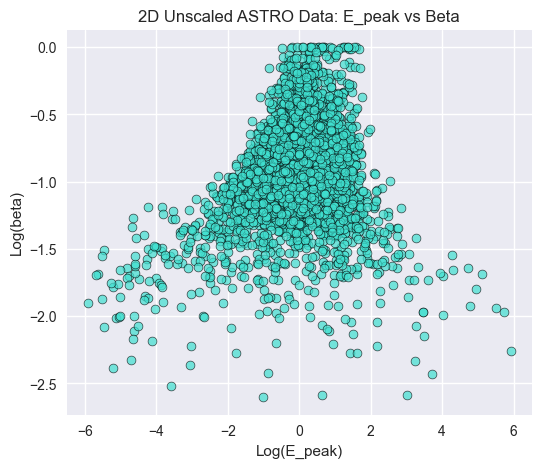

In [89]:
# Representación 2D
plt.figure(figsize=(6, 5))

sns.scatterplot(
    data=df_astro,
    x="Log(E_peak)",
    y="Log(beta)",
    color="turquoise",  # "skyblue" "cornflowerblue"
    edgecolor='k',
    alpha=0.7,
    s=40
)

plt.title("2D Unscaled ASTRO Data: E_peak vs Beta")
plt.xlabel("Log(E_peak)")
plt.ylabel("Log(beta)")
plt.grid(True)
plt.show()

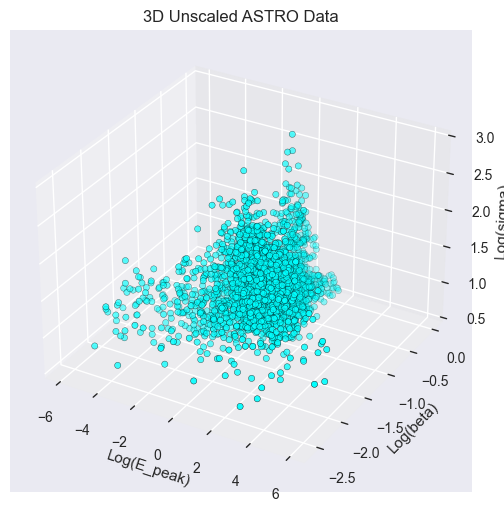

In [90]:
# Representación 3D
x = df_astro['Log(E_peak)']
y = df_astro['Log(beta)']
z = df_astro['Log(sigma)']

labels = df_astro['astro_DM']

# Plot
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, c=labels, cmap='cool', edgecolor='k')

ax.set_xlabel('Log(E_peak)')
ax.set_ylabel('Log(beta)')
ax.set_zlabel('Log(sigma)')
plt.title('3D Unscaled ASTRO Data')
plt.show()


In [91]:
# Seleccionamos las features dinámicamente
X = df_astro[features].values
y = df_astro[target].values

print(f"Forma del dataset: {X.shape}")
print(f"Distribución de clases: {np.unique(y, return_counts=True)}")

# Como todos los datos son clase 0, stratify no es necesario y puede causar errores
# Simplificamos a:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print(f"Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Forma del dataset: (2831, 4)
Distribución de clases: (array([0.]), array([2831]))
Train: 1698, Val: 566, Test: 567


In [92]:
# nu_values = [0.005, 0.01, 0.02, 0.05]
nu_values = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05]
# gamma_values = ['scale', 'auto'] + list(np.logspace(-3, 1, 5))
gamma_values = ['scale', 'auto', 0.001, 0.01, 0.1, 1, 10]

results = []
best_outliers = np.inf # Cantidad de outliers, queremos que sea el menor posible
best_score = 0.0  # F1 score (cuanto más alto, mejor)
best_model = None
best_params = {}

for nu in nu_values:
    for gamma in gamma_values:
        model = OneClassSVM(kernel='rbf', nu=nu, gamma=gamma)
        model.fit(X_train)

        # Predicciones
        preds = model.predict(X_val_scaled)              # 1 = inlier, -1 = outlier
        pred_labels = np.where(preds == 1, 0, 1)         # Mapear a 0 = normal, 1 = anomalía
        true_labels = y_val.astype(int)                  # Aseguramos tipo int
        n_outliers = np.sum(preds == -1)

        # Evaluación
        # f1 = f1_score(true_labels, pred_labels, pos_label=0)

        results.append({'nu': nu, 'gamma': gamma, 'val_outliers': n_outliers})

        """
        if f1 > best_score:
            best_score = f1
            best_model = model
            best_params = {'nu': nu, 'gamma': gamma}
        """

        if n_outliers < best_outliers:
            best_outliers = n_outliers
            best_model = model
            best_params = {'nu': nu, 'gamma': gamma}

# Resultados Finales
print("Mejor combinación de hiperparámetros:")
print(f"   - nu = {best_params['nu']}")
print(f"   - gamma = {best_params['gamma']}")
print(f"Outliers (val set): {best_outliers} de {len(X_val_scaled)} muestras")

# Convertimos resultados en DataFrame
df_results = pd.DataFrame(results)
# display(df_results.sort_values(by='f1_score', ascending=False))
display(df_results.sort_values(by='val_outliers'))

Mejor combinación de hiperparámetros:
   - nu = 0.001
   - gamma = 0.001
Outliers (val set): 0 de 566 muestras


,nu,gamma,val_outliers
2,0.001,0.001,0
9,0.002,0.001,0
16,0.005,0.001,0
23,0.010,0.001,4
30,0.020,0.001,10
3,0.001,0.01,16
10,0.002,0.01,17
24,0.010,0.01,29
31,0.020,0.01,30
37,0.050,0.001,31


In [93]:
# Entrenar modelo final con todos los datos astro (train + val)
X_final_train = np.vstack([X_train, X_val])
y_final_train = np.concatenate([y_train, y_val])

# Scaler final - SOLO ajustar con datos de entrenamiento
final_scaler = StandardScaler()
X_train_scaled = final_scaler.fit_transform(X_final_train)

# Entrenamos el modelo con los mejores hiperparámetros
best_model = OneClassSVM(kernel='rbf', nu=best_params['nu'], gamma=best_params['gamma'])
best_model.fit(X_train_scaled)

OneClassSVM(gamma=0.001, nu=0.001)

In [94]:
# CRÍTICO: Solo transform (NO fit_transform) para datos de test
X_test_scaled = final_scaler.transform(X_test)

# Evaluamos sobre los datos de prueba (X_test_scaled) con el mejor modelo ya entrenado
decision_scores_test = best_model.decision_function(X_test_scaled)
test_preds = best_model.predict(X_test_scaled)

n_test_outliers = np.sum(test_preds == -1)

print(f"Outliers en conjunto de datos reservado de prueba (test data): {n_test_outliers}")
test_labels = np.where(test_preds == 1, 0, 1)  # 1 = normal, -1 = outlier → mapeado
true_labels_test = y_test.astype(int)

Outliers en conjunto de datos reservado de prueba (test data): 1


In [95]:
print("\nMatriz de confusión (Test Set):")
print(confusion_matrix(true_labels_test, test_labels))

print("\nReporte de clasificación:")
print(classification_report(y_test, test_labels, target_names=["Normal", "Anomalía"], zero_division=1))


Matriz de confusión (Test Set):
[[566   1]
 [  0   0]]

Reporte de clasificación:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       567
    Anomalía       0.00      1.00      0.00         0

    accuracy                           1.00       567
   macro avg       0.50      1.00      0.50       567
weighted avg       1.00      1.00      1.00       567



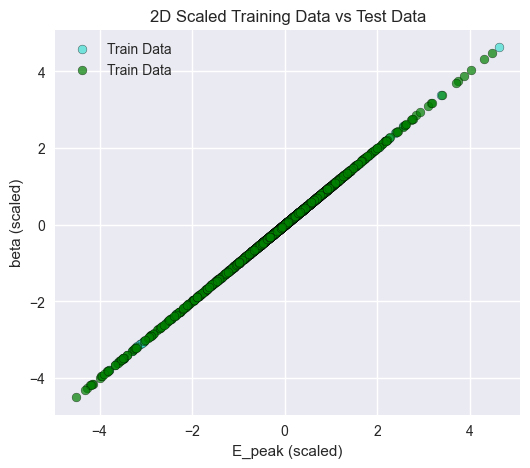

In [96]:
# Scatter de X_unids_scaled vs X_train_scaled 2D
plt.figure(figsize=(6, 5))
plt.scatter(X_test_scaled[:, 0], X_test_scaled[:, 1], color="turquoise", edgecolor='k', alpha=0.7, s=40, label="Train Data")
plt.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], color="green", edgecolor='k', alpha=0.7, s=40, label="Train Data")
plt.title("2D Scaled Training Data vs Test Data")
plt.xlabel("E_peak (scaled)")
plt.ylabel("beta (scaled)")
plt.legend()
plt.grid(True)
plt.show()

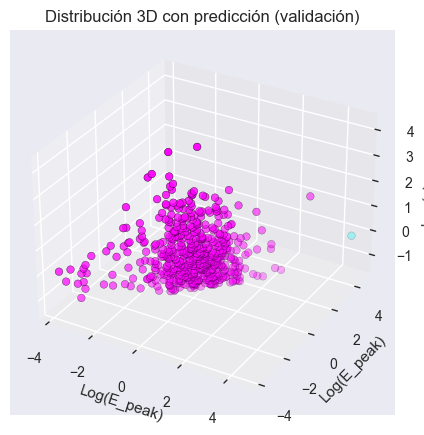

In [97]:
# Visualizamos predicciones en 3D sobre datos de validación
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_test_scaled[:, 0], X_test_scaled[:, 1], X_test_scaled[:, 2], c=test_preds, cmap='cool', edgecolor='k', s=30)

ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
ax.set_zlabel(features[2])
plt.title("Distribución 3D con predicción (validación)")
plt.show()

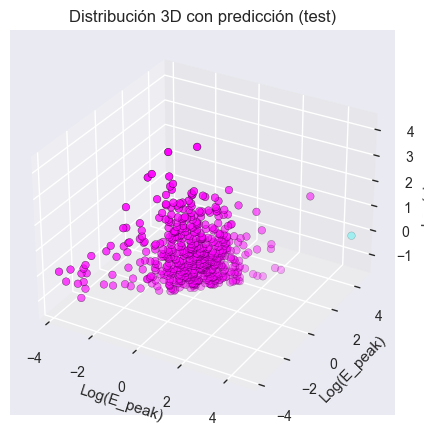

In [98]:
# Visualizamos predicciones en 3D sobre datos de prueba
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_test_scaled[:, 0], X_test_scaled[:, 1], X_test_scaled[:, 2], c=test_preds, cmap='cool', edgecolor='k', s=30)

ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
ax.set_zlabel(features[2])
plt.title("Distribución 3D con predicción (test)")
plt.show()

# UNIDs

In [99]:
# unids_path = "../../data/raw/unids_3F_beta_err_names.txt"
unids_path = "../../data/processed/unids_log/unids_transformed_complete.txt"

df_unids = pd.read_csv(unids_path, sep='\s+')
df_unids.head()

,Log(E_peak),Log(beta),Log(sigma),Log(beta_Rel),number
0,0.400175,-1.047208,0.869208,0.212452,0
1,0.169733,-0.380594,0.733598,-0.113037,1
2,0.203142,-0.168578,1.033058,-0.430366,2
3,-0.031074,-0.557363,0.881133,-0.201588,3
4,-0.351835,-0.493901,0.630916,-0.246028,4


In [100]:
# Extraer y escalar
X_unids_log = df_unids[["Log(E_peak)", "Log(beta)", "Log(sigma)", "Log(beta_Rel)"]].values
X_unids_scaled = scaler.transform(X_unids_log)

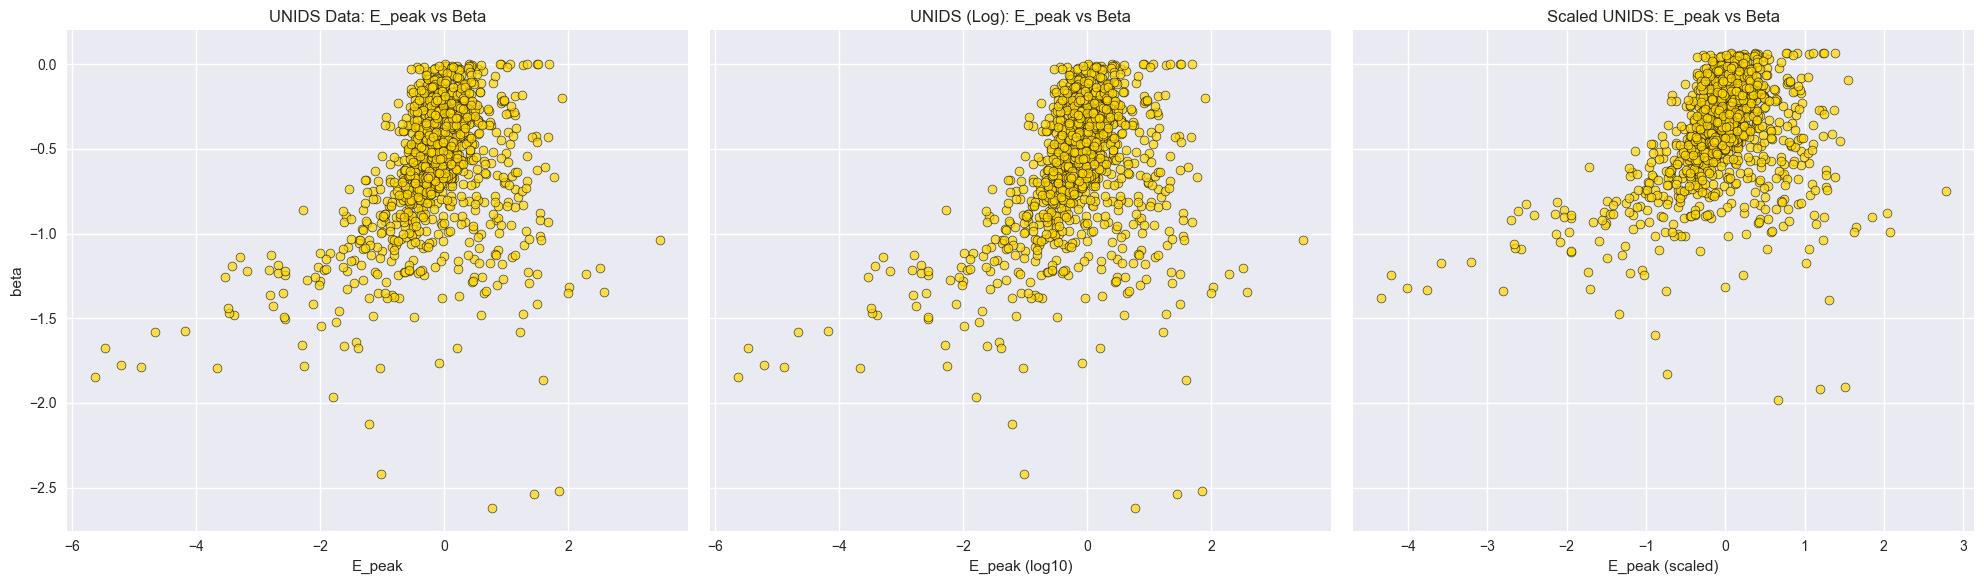

In [101]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

sns.scatterplot(
    data=df_unids,
    x="Log(E_peak)",
    y="Log(beta)",
    color="gold",
    edgecolor='k',
    alpha=0.7,
    s=40,
    ax=axes[0]
)
axes[0].set_title("UNIDS Data: E_peak vs Beta")
axes[0].set_xlabel("E_peak")
axes[0].set_ylabel("beta")
axes[0].grid(True)

sns.scatterplot(
    data=df_unids,
    x="Log(E_peak)",
    y="Log(beta)",
    color="gold",
    edgecolor='k',
    alpha=0.7,
    s=40,
    ax=axes[1]
)
axes[1].set_title("UNIDS (Log): E_peak vs Beta")
axes[1].set_xlabel("E_peak (log10)")
axes[1].set_ylabel("")  # hide repeated ylabel
axes[1].grid(True)

sns.scatterplot(
    x=X_unids_scaled[:, 0],
    y=X_unids_scaled[:, 1],
    color="gold",
    edgecolor='k',
    alpha=0.7,
    s=40,
    ax=axes[2]
)
axes[2].set_title("Scaled UNIDS: E_peak vs Beta")
axes[2].set_xlabel("E_peak (scaled)")
axes[2].set_ylabel("")  # hide repeated ylabel
axes[2].grid(True)

plt.tight_layout()
plt.show()


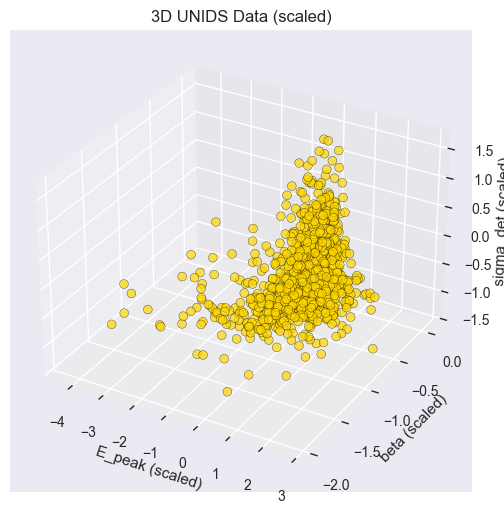

In [102]:
# Visualización de 3D de UNIDS
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_unids_scaled[:, 0], X_unids_scaled[:, 1], X_unids_scaled[:, 2], color="gold", edgecolor='k', alpha=0.7, s=40)
ax.set_xlabel('E_peak (scaled)')
ax.set_ylabel('beta (scaled)')
ax.set_zlabel('sigma_det (scaled)')
plt.title('3D UNIDS Data (scaled)')
plt.show()

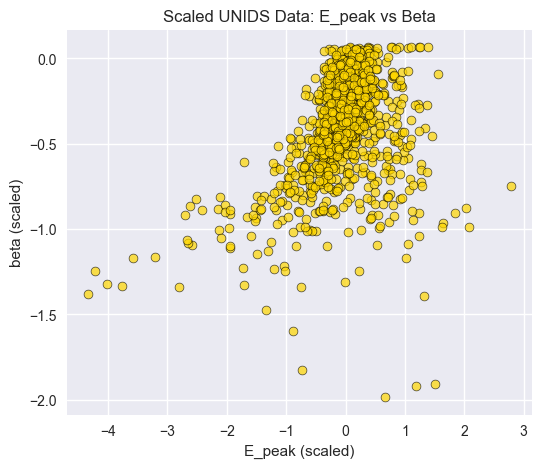

In [103]:
# Scatter de unids después de escalar
plt.figure(figsize=(6, 5))
sns.scatterplot(
    x=X_unids_scaled[:, 0],
    y=X_unids_scaled[:, 1],
    color="gold",
    edgecolor='k',
    alpha=0.7,
    s=40
)
plt.title("Scaled UNIDS Data: E_peak vs Beta")
plt.xlabel("E_peak (scaled)")
plt.ylabel("beta (scaled)")
plt.grid(True)
plt.show()

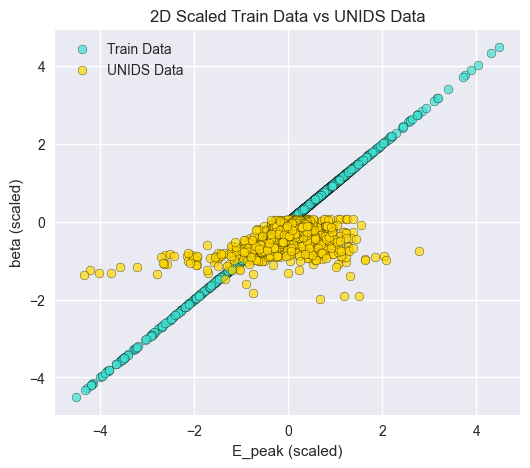

In [104]:
# Scatter de X_unids_scaled vs X_train_scaled 2D
plt.figure(figsize=(6, 5))
plt.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], color="turquoise", edgecolor='k', alpha=0.7, s=40, label="Train Data")
plt.scatter(X_unids_scaled[:, 0], X_unids_scaled[:, 1], color="gold", edgecolor='k', alpha=0.7, s=40, label="UNIDS Data")
plt.title("2D Scaled Train Data vs UNIDS Data")
plt.xlabel("E_peak (scaled)")
plt.ylabel("beta (scaled)")
plt.legend()
plt.grid(True)
plt.show()

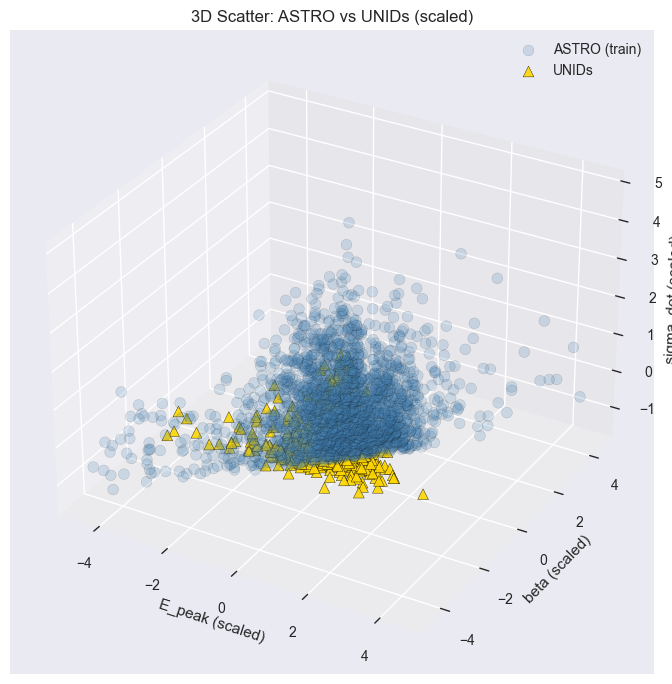

In [105]:
# Scatter de UNIDs vs ASTRO 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter ASTRO (training data)
ax.scatter(
    X_train_scaled[:, 0], X_train_scaled[:, 1], X_train_scaled[:, 2],
    color="steelblue", edgecolor='k', alpha=0.2, s=60, label='ASTRO (train)',
)

# Scatter UNIDs (to predict)
ax.scatter(
    X_unids_scaled[:, 0], X_unids_scaled[:, 1], X_unids_scaled[:, 2],
    color="gold", edgecolor='k', alpha=0.9, s=60, label='UNIDs',
    marker='^'
)

ax.set_xlabel('E_peak (scaled)')
ax.set_ylabel('beta (scaled)')
ax.set_zlabel('sigma_det (scaled)')
ax.set_title('3D Scatter: ASTRO vs UNIDs (scaled)')

ax.legend()
plt.tight_layout()
plt.show()


In [106]:
# Predicciones sobre UNIDS
unids_preds = best_model.predict(X_unids_scaled)

n_unids_outliers = np.sum(unids_preds == -1)
n_unids_normals = np.sum(unids_preds == 1)

print(f" Predicted ASTRO-like: {n_unids_normals}")
print(f" Predicted not ASTRO-like (anomalies): {n_unids_outliers}")
unids_labels = np.where(unids_preds == 1, 0, 1)  # 1 = normal, -1 = outlier → mapeado

 Predicted ASTRO-like: 1125
 Predicted not ASTRO-like (anomalies): 0


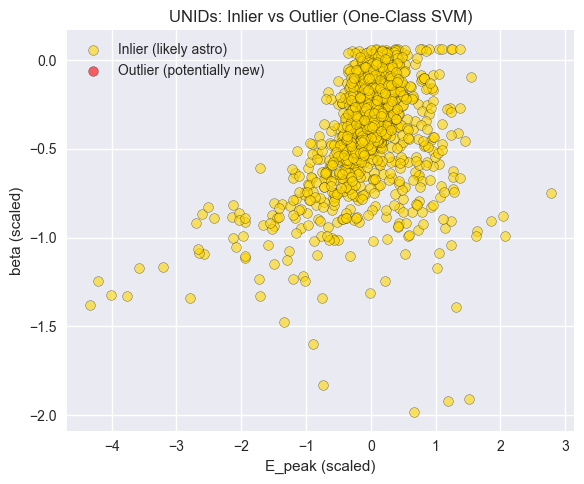

In [107]:
inliers = X_unids_scaled[unids_preds == 1]
outliers = X_unids_scaled[unids_preds == -1]

plt.figure(figsize=(6, 5))
plt.scatter(inliers[:, 0], inliers[:, 1], c='gold', edgecolors='k', label='Inlier (likely astro)', alpha=0.6)
plt.scatter(outliers[:, 0], outliers[:, 1], c='red', edgecolors='k', label='Outlier (potentially new)', alpha=0.6)

plt.xlabel("E_peak (scaled)")
plt.ylabel("beta (scaled)")
plt.title("UNIDs: Inlier vs Outlier (One-Class SVM)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

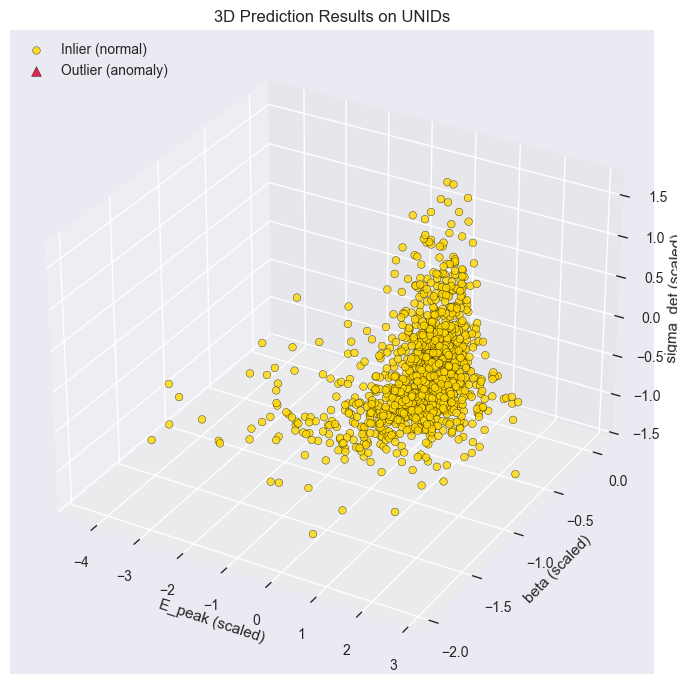

In [108]:
# Visualizamos predicciones en 3D sobre UNIDS

# Get predictions from best model on UNIDs
preds = best_model.predict(X_unids_scaled)  # 1 = inlier, -1 = outlier

# Separate indices
inlier_idx = preds == 1
outlier_idx = preds == -1

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Inliers (normal)
ax.scatter(
    X_unids_scaled[inlier_idx, 0], X_unids_scaled[inlier_idx, 1], X_unids_scaled[inlier_idx, 2],
    c='gold', edgecolor='k', s=30, label='Inlier (normal)', alpha=0.8
)

# Outliers (potential dark matter)
ax.scatter(
    X_unids_scaled[outlier_idx, 0], X_unids_scaled[outlier_idx, 1], X_unids_scaled[outlier_idx, 2],
    c='crimson', marker='^', edgecolor='k', s=50, label='Outlier (anomaly)', alpha=0.9
)

ax.set_xlabel('E_peak (scaled)')
ax.set_ylabel('beta (scaled)')
ax.set_zlabel('sigma_det (scaled)')
ax.set_title("3D Prediction Results on UNIDs")

ax.legend(loc='upper left')
plt.tight_layout()
plt.show()


# Anomaly Scoring - UNIDs

In [109]:
# Paso 1: Evaluar cada muestra no identificada con el modelo entrenado
# decision_function devuelve un valor continuo: cuanto más alto, más normal (positivo); cuanto más bajo, más anómalo (negativo)
decision_scores = best_model.decision_function(X_unids_scaled)  # X_unids_scaled = muestras no etiquetadas, ya escaladas

# Paso 2: Predecir si cada punto es inlier (1) o outlier (-1)
unids_preds = best_model.predict(X_unids_scaled)  # 1 = normal, -1 = anomalía

# Paso 3: Agregar los resultados al DataFrame original
df_unids_log["svm_score"] = decision_scores       # Puntaje bruto del modelo (positivo = normal)
df_unids_log["prediction"] = unids_preds          # Clasificación binaria: inlier o outlier

# Paso 4: Invertimos el score para que valores más altos signifiquen más anomalía
# Esto es útil para poder escalar la puntuación y ordenar más intuitivamente
anom_scores = -decision_scores  # Ahora, valores grandes = más anómalos

# Paso 5: Escalamos los scores de anomalía al rango [0, 100] para facilitar su interpretación
anom_percent = MinMaxScaler(feature_range=(0, 100)).fit_transform(anom_scores.reshape(-1, 1)).flatten()

# Guardamos el puntaje invertido y su porcentaje normalizado en el DataFrame
df_unids_log["Anomaly_Score"] = anom_scores
df_unids_log["Anomaly_Rank(%)"] = anom_percent  # 100 = más anómalo, 0 = más normal

# Paso 6: Filtramos solo los puntos predichos como anómalos y los ordenamos por su score más alto
top_anomalies = df_unids_log[df_unids_log["prediction"] == -1] \
                    .sort_values(by="Anomaly_Rank(%)", ascending=False) \
                    .head(10)

# Guardamos los índices (puede ser útil si queremos recuperar sus posiciones originales)
most_anomalous_idx = top_anomalies.index

# Paso 7: Guardamos los 10 más anómalos en un archivo
top_anomalies.to_csv("../../data/processed/unids_most_anomalous_4F.txt", sep="\t", index=False)

# Paso 8: Mostramos en pantalla un resumen de las anomalías detectadas
print("Top Most Anomalous UNID Sources (4F One-Class SVM):")
display(top_anomalies[['E_peak', 'beta', 'number', 'svm_score', 'Anomaly_Score', 'Anomaly_Rank(%)']])


Top Most Anomalous UNID Sources (4F One-Class SVM):


,E_peak,beta,number,svm_score,Anomaly_Score,Anomaly_Rank(%)


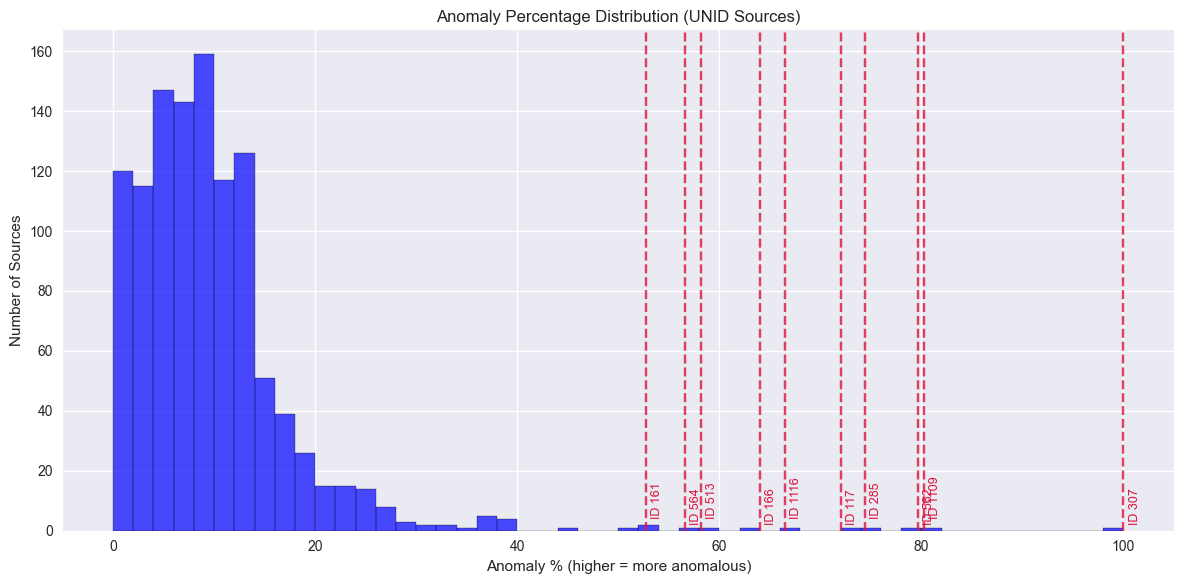

In [110]:
# Sort anomaly scores and grab top N labels
N = 10
sorted_idx = np.argsort(-anom_percent)  # high anomaly % = more anomalous
top_N_idx = sorted_idx[:N]

top_labels = df_unids_log.iloc[top_N_idx]['number'].astype(str).values
top_scores = anom_percent[top_N_idx]

plt.figure(figsize=(12, 6))
plt.hist(anom_percent, bins=50, color='blue', edgecolor='k', alpha=0.7)
plt.title("Anomaly Percentage Distribution (UNID Sources)")
plt.xlabel("Anomaly % (higher = more anomalous)")
plt.ylabel("Number of Sources")

for i in range(N):
    x = top_scores[i]
    label = top_labels[i]
    plt.axvline(x, color='crimson', linestyle='--', alpha=0.8)
    plt.text(x + 0.5, 3 + (i % 2) * 2, f"ID {label}", rotation=90, color='crimson', ha='left', fontsize=9)

plt.grid(True)
plt.tight_layout()
plt.show()


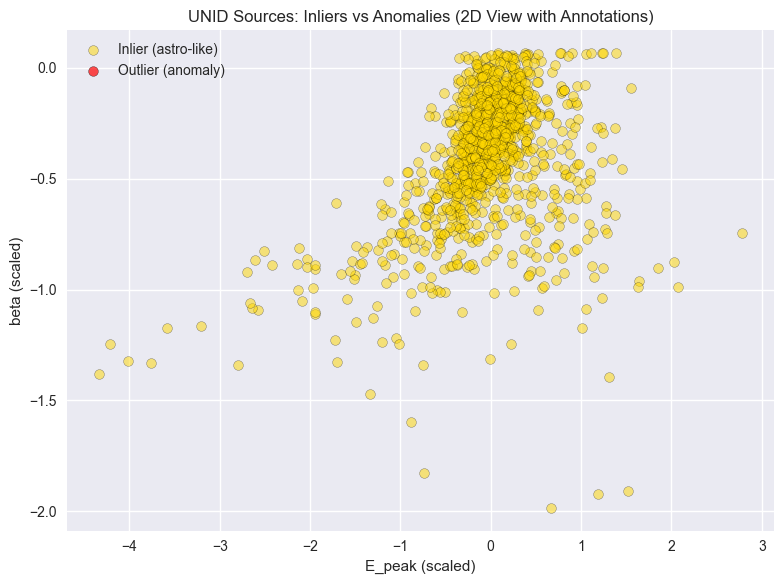

In [111]:
# Get scaled values (for consistent comparison)
X_unids = X_unids_scaled  # already scaled

# Separate inliers and outliers
inliers = X_unids[unids_preds == 1]
outliers = X_unids[unids_preds == -1]

# Get anomaly info
top_anomalies = df_unids_log[df_unids_log["prediction"] == -1].sort_values(by="Anomaly_Rank(%)", ascending=False).head(10)
most_anomalous_idx = top_anomalies.index

# Extract for plotting
E_peak = X_unids[:, 0]
beta = X_unids[:, 1]

# Plot
plt.figure(figsize=(8, 6))

# All points
plt.scatter(inliers[:, 0], inliers[:, 1], c='gold', edgecolors='k', label='Inlier (astro-like)', alpha=0.5)
plt.scatter(outliers[:, 0], outliers[:, 1], c='red', edgecolors='k', label='Outlier (anomaly)', alpha=0.7)

# Highlight & label top anomalies
for idx in most_anomalous_idx:
    x = X_unids[idx, 0]
    y = X_unids[idx, 1]
    source_id = df_unids_log.loc[idx, 'number']
    
    plt.scatter(x, y, facecolors='none', edgecolors='black', linewidths=1.5, s=100)
    plt.text(x + 0.1, y, str(int(source_id)), color='black', fontsize=9)

# Labels and layout
plt.xlabel("E_peak (scaled)")
plt.ylabel("beta (scaled)")
plt.title("UNID Sources: Inliers vs Anomalies (2D View with Annotations)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


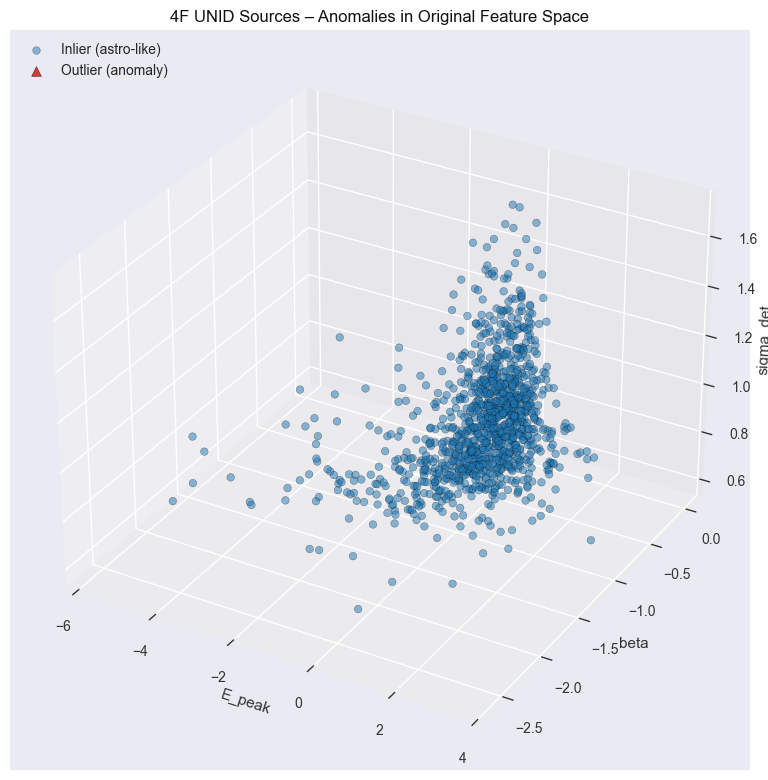

In [112]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Original/log-transformed values for 3 relevant features
x_vals = df_unids_log['E_peak'].values
y_vals = df_unids_log['beta'].values
z_vals = df_unids_log['sigma_det'].values  # or 'beta_Rel' for 3F.2

# Use model predictions for coloring
inlier_idx = df_unids_log['prediction'] == 1
outlier_idx = df_unids_log['prediction'] == -1

# Inliers
ax.scatter(
    x_vals[inlier_idx], y_vals[inlier_idx], z_vals[inlier_idx],
    c='#1f77b4', edgecolor='k', s=30, label='Inlier (astro-like)', alpha=0.5
)

# Outliers
ax.scatter(
    x_vals[outlier_idx], y_vals[outlier_idx], z_vals[outlier_idx],
    c='#d62728', marker='^', edgecolor='k', s=50, label='Outlier (anomaly)', alpha=0.9
)

# Annotate top anomalies
top_anomalies = df_unids_log[df_unids_log['prediction'] == -1].sort_values('Anomaly_Rank(%)', ascending=False).head(10)
for idx in top_anomalies.index:
    ax.scatter(
        x_vals[idx], y_vals[idx], z_vals[idx],
        facecolors='none', edgecolors='black', linewidths=2, s=100
    )
    ax.text(
        x_vals[idx], y_vals[idx], z_vals[idx] + 0.05,
        str(int(df_unids_log.loc[idx, 'number'])),
        color='black', fontsize=9
    )

ax.set_xlabel('E_peak')
ax.set_ylabel('beta')
ax.set_zlabel('sigma_det')  # or 'beta_Rel'
ax.set_title("4F UNID Sources – Anomalies in Original Feature Space")
ax.legend(loc='upper left')

ax.tick_params(colors='#333333')
ax.xaxis.label.set_color('#333333')
ax.yaxis.label.set_color('#333333')
ax.zaxis.label.set_color('#333333')
ax.title.set_color('#111111')
ax.grid(color='#aaaaaa', linestyle='--', alpha=0.3)

plt.savefig("../../outputs/figures/4F_UNIDs_OneClassSVM_og.png", dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

# Compare UNIDs most anomalous vs ANN most DM-like

In [113]:
# === 1. Cargar los datos de unIDs (features)
unids_3F = np.genfromtxt('../../data/raw/unids_3F_beta_err_names.txt', dtype='str') 
unids_3F_data = np.asarray(unids_3F[1:, :], dtype=float)
unids_log = np.log10(unids_3F_data[:, [0,1,2,3]])

N_unids = unids_log.shape[0]
N_splits = 5
N_Repeats = 1
N_sample = N_splits * N_Repeats

# === 2. Cargar las predicciones ANN 4F
ann_unids_path = "../../ANN_original/unids_DM_std_proba_check_repeated_kfold_rskf_4F_21.txt"
unids_DM_raw = np.genfromtxt(ann_unids_path, dtype='str')[1:]  # quitar cabecera
unids_DM_data = np.asarray(unids_DM_raw, dtype=float)

# === 3. Reconstruir matriz (N_unids, N_sample)
unids_number = unids_DM_data[:N_unids, 0]  # índice de los unIDs
prob_matrix = np.reshape(unids_DM_data[:, 1], (N_unids, N_sample))

# === 4. Calcular media y desviación estándar por unID
unids_mean = prob_matrix.mean(axis=1)
unids_std = prob_matrix.std(axis=1, ddof=1)

In [114]:
# === 5. Crear DataFrame con resultados ANN
df_ann = pd.DataFrame({
    'unid_idx': unids_number.astype(int),
    'ann_mean_prob': unids_mean,
    'ann_std_prob': unids_std
})

df_ann.head()


,unid_idx,ann_mean_prob,ann_std_prob
0,0,0.318913,0.268862
1,1,0.035178,0.075001
2,2,0.106853,0.165058
3,3,0.067615,0.092273
4,4,0.236240,0.323552


In [115]:
# === 6. Asegurar coincidencia de identificadores
df_unids_log['unid_idx'] = df_unids_log['number'].astype(int)

# === 7. Unir con resultados de OCSVM
df_combined = pd.merge(df_unids_log, df_ann, on="unid_idx", how="inner")

df_combined.head()

,E_peak,beta,sigma_det,beta_Rel,number,svm_score,prediction,Anomaly_Score,Anomaly_Rank(%),unid_idx,ann_mean_prob,ann_std_prob
0,0.400175,-1.047208,0.869208,0.212452,0,0.089426,1,-0.089426,11.648154,0,0.318913,0.268862
1,0.169733,-0.380594,0.733598,-0.113037,1,0.090973,1,-0.090973,9.821126,1,0.035178,0.075001
2,0.203142,-0.168578,1.033058,-0.430366,2,0.097194,1,-0.097194,2.475366,2,0.106853,0.165058
3,-0.031074,-0.557363,0.881133,-0.201588,3,0.094190,1,-0.094190,6.022338,3,0.067615,0.092273
4,-0.351835,-0.493901,0.630916,-0.246028,4,0.088855,1,-0.088855,12.321537,4,0.236240,0.323552


In [116]:
# === 8. Análisis de solapamiento
print("Total unIDs ann:", len(df_ann))
print("Total unIDs ocsvm:", len(df_unids_log))
print("High ANN prob (≥0.9):", (df_ann['ann_mean_prob'] >= 0.9).sum())
print("High ANN prob (≥0.7):", (df_ann['ann_mean_prob'] >= 0.7).sum())
print("High ANN prob (≥0.5):", (df_ann['ann_mean_prob'] >= 0.5).sum())
print("Predicted anomalies (OCSVM):", (df_unids_log['prediction'] == -1).sum())
print("Anomaly rank ≥95%:", (df_unids_log['Anomaly_Rank(%)'] >= 95).sum())

Total unIDs ann: 1125
Total unIDs ocsvm: 1125
High ANN prob (≥0.9): 0
High ANN prob (≥0.7): 4
High ANN prob (≥0.5): 39
Predicted anomalies (OCSVM): 0
Anomaly rank ≥95%: 1


In [117]:
# === 9. Extraer unIDs destacados por ambos modelos
p_cut = 0.4
anom_cut = 40

top_candidates = df_combined[
    (df_combined["ann_mean_prob"] >= p_cut) &
    (df_combined["Anomaly_Rank(%)"] >= anom_cut)
].sort_values(by="Anomaly_Rank(%)", ascending=False).head(10)

print("Top UNIDs by ANN and OCSVM agreement:")
display(top_candidates[["unid_idx", "E_peak", "beta", "ann_mean_prob", "Anomaly_Rank(%)", "Anomaly_Score"]])

Top UNIDs by ANN and OCSVM agreement:


,unid_idx,E_peak,beta,ann_mean_prob,Anomaly_Rank(%),Anomaly_Score
161,161,-4.66322,-1.581699,0.411086,52.71394,-0.054648


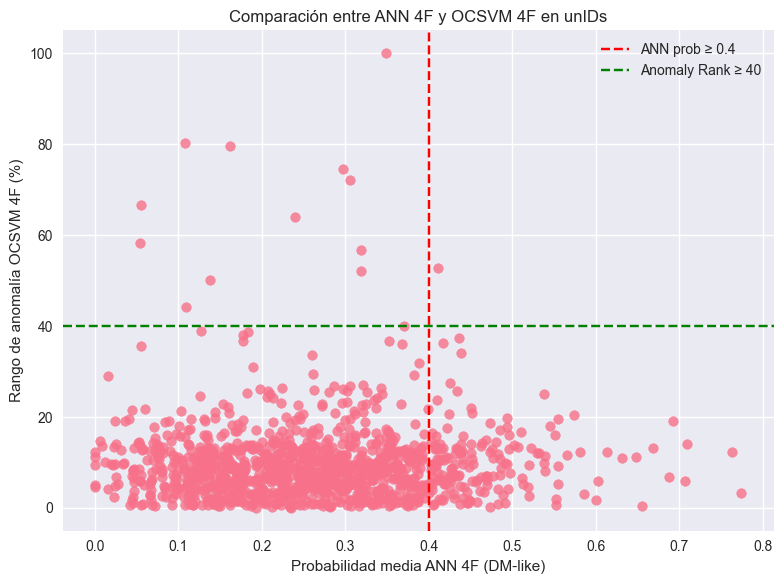

In [118]:
plt.figure(figsize=(8, 6))
plt.scatter(df_combined["ann_mean_prob"], df_combined["Anomaly_Rank(%)"], alpha=0.8)
plt.axvline(p_cut, color='red', linestyle='--', label=f'ANN prob ≥ {p_cut}')
plt.axhline(anom_cut, color='green', linestyle='--', label=f'Anomaly Rank ≥ {anom_cut}')
plt.xlabel("Probabilidad media ANN 4F (DM-like)")
plt.ylabel("Rango de anomalía OCSVM 4F (%)")
plt.title("Comparación entre ANN 4F y OCSVM 4F en unIDs")
plt.grid(True)
plt.legend()
plt.tight_layout()
# plt.savefig("comparacion_ann4f_ocsvm4f.png", dpi=300)
plt.show()